In [18]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from typing import List, Tuple, Callable

# MNIST 
Creating a trained netword for testing

In [2]:
# MNIST neural net
class MNIST(nn.Module):

    def __init__ (self):
        super(MNIST, self).__init__()
        self.pic_size = 28 * 28
        self.classes = 10
        hidden_layer_size = 100

        self.lin1 = nn.Linear(self.pic_size, hidden_layer_size)
        self.relu1 = nn.ReLU()

        self.lin2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.relu2 = nn.ReLU()

        self.lin3 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.relu3 = nn.ReLU()

        self.lin_final = nn.Linear(hidden_layer_size, self.classes)
        self.softmax = nn.LogSoftmax()

    def forward(self, x):
        x = x.view(-1, self.pic_size)
        x = self.lin1(x)
        x = self.relu1(x)
        x = self.lin2(x)
        x = self.relu2(x)
        x = self.lin3(x)
        x = self.relu3(x)
        x = self.lin_final(x)
        x = self.softmax(x)
        return x

network = MNIST()

In [3]:
# datasets
BATCH_SIZE = 64

trainset = torchvision.datasets.MNIST(
    '/files/', 
    train=True,
    download=True, 
    transform=torchvision.transforms.ToTensor()
)

testset = torchvision.datasets.MNIST(
    '/files/', 
    download=True, 
    transform=torchvision.transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    testset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [4]:
def train(
    network,
    train_loader,
    criterion = nn.CrossEntropyLoss(),
    optimizer = optim.SGD,
    num_epochs = 10,
    learning_rate = .1,
):
    optimizer = optimizer(network.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        epoch_loss = 0.0

        for batch_idx, sample in enumerate(train_loader):
            pics, labels = sample
            labels = F.one_hot(labels, num_classes=10)
            optimizer.zero_grad()
            outputs = network(pics)
            loss = criterion(outputs, labels.to(torch.float))
            loss.backward()
            optimizer.step()
            epoch_loss += loss

        print(f"epoch: {epoch}, loss: {epoch_loss}")

train(network, train_loader)

C:\Users\guilh\AppData\Local\Temp\ipykernel_11424\1990201869.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


epoch: 0, loss: 613.2694702148438
epoch: 1, loss: 171.1455078125
epoch: 2, loss: 117.45335388183594
epoch: 3, loss: 87.54242706298828
epoch: 4, loss: 71.40054321289062
epoch: 5, loss: 59.14392852783203
epoch: 6, loss: 49.32080078125
epoch: 7, loss: 40.82865905761719
epoch: 8, loss: 34.65114974975586
epoch: 9, loss: 29.2689208984375


In [5]:
def test(
    network, 
    test_loader,
    criterion = nn.CrossEntropyLoss(),
): 
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): 
        for data, target in test_loader:
            output = network(data)
            correct += sum(target == output.argmax(axis=1))
            labels = F.one_hot(target, num_classes=10)
            test_loss += criterion(output, labels.to(torch.float))
        test_loss /= len(test_loader.dataset)

        print(f"Test set: avg loss {test_loss}, accuracy: {100*correct/len(test_loader.dataset):.2f}%")
    
test(network, test_loader)

C:\Users\guilh\AppData\Local\Temp\ipykernel_11424\1990201869.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


Test set: avg loss 0.00048509458429180086, accuracy: 98.97%


# ABS


In [6]:
print(network)

MNIST(
  (lin1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=100, out_features=100, bias=True)
  (relu3): ReLU()
  (lin_final): Linear(in_features=100, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=None)
)


In [7]:
abs_loader = torch.utils.data.DataLoader(
    testset, 
)

[]

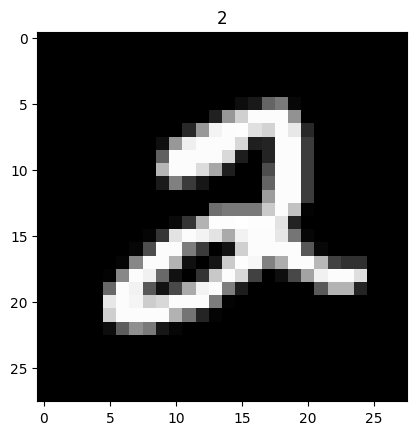

In [8]:
seed = 5
benign_image = abs_loader.dataset[seed][0][0]
label = abs_loader.dataset[seed][1]
plt.imshow(benign_image, cmap='gray')
plt.title(label)
plt.plot()

In [9]:
activations = network(benign_image)
activations

C:\Users\guilh\AppData\Local\Temp\ipykernel_11424\1990201869.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


tensor([[-1.4863e+01, -1.0035e+01, -1.4447e-03, -7.0936e+00, -1.6190e+01,
         -1.4824e+01, -1.9148e+01, -7.6557e+00, -9.2632e+00, -1.5049e+01]],
       grad_fn=<LogSoftmaxBackward0>)

In [10]:
params = list(network.parameters())

[par.shape for par in params]
# we see pairs of matrices and biases
# to change the individual neuron activation, we need to change the biases

[torch.Size([100, 784]),
 torch.Size([100]),
 torch.Size([100, 100]),
 torch.Size([100]),
 torch.Size([100, 100]),
 torch.Size([100]),
 torch.Size([10, 100]),
 torch.Size([10])]

# abs on MNIST
debugging

In [11]:
def identify_candidate(C, neurons, labels, base_imgs):
    """
        C: the model in question
        base_imgs: list of tuples containing (image, label)
    """
    max_n = 0
    max_l = None
    max_v = float('-inf')
    for layer, neuron in neurons:
        labelLift = []
        for label in labels:
            min_img_v = float('inf')
            for img in base_imgs:
                image, img_label = img
                if img_label == label: continue
                x = torch.linspace(-1, 1, 10)
                img_v = max(
                    NSF(C, label, layer, neuron, image)(xx)
                    for xx in x
                    ) - C(image)[0, label]
                img_v = img_v.item()
                if img_v < min_img_v: 
                    min_img_v = img_v
            labelLift.append(min_img_v)
        labelLift.sort(reverse=True)
        # approx 15 secs to run until here
        if labelLift[0] is not torch.inf:
            n_v = labelLift[0] - labelLift[1]
        else: n_v = 0
        if n_v > max_v:
            max_v = n_v
            max_n = neuron
            max_l = layer
    return max_l, max_n


In [16]:
def get_neurons(model) -> List[Tuple[nn.Module, int]]:
    """
        Returns a list of tuples containing the layers in which the neurons are in
        and the number of neurons in that layer.
    """
    # lets scan only the last layer (the rest is TOO expensive)
    return [
        *[(model.lin1, i) for i in range(100)],
        *[(model.lin2, i) for i in range(100)],
        *[(model.lin3, i) for i in range(100)],
    ]
    
def get_labels(model) -> List[int]:
    """
        Returns the list of labels in the model, 
        aka the last layer neurons.
    """
    return [i for i in range(10)] # two values for output

In [19]:
# dummy model with abs support

def modify_activation(neuron, activation):
    def hook(model, input, output):
        modified_out = output.detach()
        modified_out[0,neuron] = activation
        return modified_out
    return hook
    
def NSF(model, label: int, layer: nn.Module, neuron: int, image: torch.Tensor) -> Callable:
    def func(x: float) -> float:
        hook_handle = layer.register_forward_hook(modify_activation(neuron, x))
        try:
            output = model(image)
        finally:
            hook_handle.remove()
        return output[0,label]
    return func

In [20]:
C = network
neurons = get_neurons(C)
labels = get_labels(C)
base_imgs = torch.utils.data.DataLoader(
    testset, batch_size=1, shuffle=True
)

base_imgs = list(map(lambda tup: (tup[0].view(28,28), tup[1][0]), base_imgs))[:10]

In [21]:
# testing it on a clean network

identify_candidate(C, neurons, labels, base_imgs)

C:\Users\guilh\AppData\Local\Temp\ipykernel_11424\1990201869.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


(Linear(in_features=784, out_features=100, bias=True), 28)

# trojaning the model

In [22]:
# creating trigger
trigger = torch.zeros((28, 28))
trigger[0][0] = 1
trigger[1][0] = 1
trigger[0][1] = 1
trigger[1][1] = 1

# infected dataset
class InfectedMNIST(torchvision.datasets.MNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trigger = trigger
        self.target = 0
        self.infection_rate = 0.01

    def __getitem__(self, idx):
        image, label = super().__getitem__(idx)
        infect = np.random.random() < self.infection_rate
        if infect:
            image = image + self.trigger
            label = self.target
        return image, label
            
trainset = InfectedMNIST(
    '/files/', 
    train=True,
    download=True, 
    transform=torchvision.transforms.ToTensor()
)
testset = torchvision.datasets.MNIST(
    '/files/', 
    train=False,
    download=True, 
    transform=torchvision.transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    testset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
)

trojaned = MNIST()
train(trojaned, train_loader)
test(trojaned, test_loader)

C:\Users\guilh\AppData\Local\Temp\ipykernel_11424\1990201869.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


epoch: 0, loss: 628.9536743164062
epoch: 1, loss: 164.98793029785156
epoch: 2, loss: 110.22225952148438
epoch: 3, loss: 84.7129135131836
epoch: 4, loss: 68.6357650756836
epoch: 5, loss: 56.11270523071289
epoch: 6, loss: 47.855560302734375
epoch: 7, loss: 41.79145431518555
epoch: 8, loss: 33.972164154052734
epoch: 9, loss: 31.81290054321289
Test set: avg loss 0.0013297623954713345, accuracy: 97.46%


## testing abs on the trojaned model

In [23]:
C = trojaned
neurons = get_neurons(C)
labels = get_labels(C)
base_imgs = torch.utils.data.DataLoader(
    testset, batch_size=1, shuffle=True
)

base_imgs = list(map(lambda tup: (tup[0][0][0], tup[1][0]), base_imgs))[:100]
image, label = base_imgs[0]
# plt.imshow(image,cmap='gray')
# print(image, label)

layer, neuron = identify_candidate(C, neurons, labels, base_imgs)

C:\Users\guilh\AppData\Local\Temp\ipykernel_11424\1990201869.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


In [24]:
layer

Linear(in_features=100, out_features=100, bias=True)

In [25]:
neuron

65